In [3]:
import numpy as np
from qutip import wigner, fock, Qobj, displace, destroy, tensor, qeye, coherent
from scipy.special import genlaguerre
from math import sqrt, factorial
import qutip
import matplotlib.pyplot as plt
from scipy.linalg import lstsq, eigh, svd  
from scipy.sparse.linalg import LinearOperator, lsqr
import h5py
from tcsim.visualization import*
from qutip import*
from tcsim.visualization import*

def make_disps(xmax, N):
    xs = np.linspace(-xmax, xmax, N)
    X, Y = np.meshgrid(xs, xs)
    return (X + 1j*Y).flatten()
# flatten means a matrix can be transformed to a list with the order of row.

def vectorize(rho):
    """
    Turn hermitian matrix rho into a real vector
    vectorize(rho)[:d] = diag(rho)
    vectorize(rho)[d:d + d*(d-1)/2] = Re[upper_triangle(rho)]
    vectorize(rho)[d + d*(d-1)/2:]  = Im[upper_triangle(rho)]
    """
    d = rho.shape[0]  ## the shape of first column - dimension of matrix, e.g. 3x3 matrix d = 3
    n_offd = d*(d-1)//2 
    ret = np.zeros(d**2) #array of zeros with dimensionality d**2
    i = 0
    for m in range(d):
        ret[m] = rho[m, m].real #mth entry in ret is real part of (m,m) diagonal entry of matrix, capped at d
        for n in range(m+1, d):
            ret[d+i] = rho[m, n].real  #set d+ith entry in ret to real part of (m,n) off diagonal entry of matrix
            ret[d+n_offd+i] = rho[m, n].imag
            i += 1
    return ret


def matricize(rvec):
    """
    Invert the vectorize operation such that matricize(vectorize(rho)) == rho
    """
    d = int(np.sqrt(len(rvec)))
    n_offd = d*(d-1)//2
    ret = np.diag(rvec[:d]).astype(np.complex) # 将rvec[:d]转化为一个对角矩阵，并且用a+jb的形式表示
    i = 0
    for m in range(d):
        for n in range(m+1, d):
            real = rvec[d+i]
            imag = rvec[d+n_offd+i]
            val = real + 1j*imag
            ret[m, n] = val
            ret[n, m] = val.conj()
            i += 1
    return ret


def complex_char_mat(disps, d):
    n_disp = len(disps)
    n_offd = (d*(d-1))//2
    dm = np.zeros((n_disp, d*d), dtype=np.complex)
    alpha = disps
    i = 0
    B = abs(alpha)**2
    for n in range(d):
        dm[:, n] = genlaguerre(n, 0)(B)
        for m in range(n+1, d):
            off_d = np.sqrt(factorial(n)/factorial(m)) * genlaguerre(n, m-n)(B)
            dm[:, d+i] = (off_d * (alpha**(m-n) + (-alpha.conjugate())**(m-n)))
            dm[:, d + n_offd + i] = (1j * off_d * (alpha**(m-n) - (-alpha.conjugate())**(m-n)))
            i += 1
    dm = np.einsum('ij,i->ij', dm, np.exp(-B / 2))
    return dm

def reconstruct_char_complex(char, disps, dim):
    M = complex_char_mat(disps, dim)
    rv = lsqr(M, char, damp = 2)[0]
    rho = matricize(rv)
    return rho



def reconstruct_char_from_data(data, x_data, y_data, dim, scale, plot=True):
  
    # turn x_data and y_data into an appropriate grid and flatten to hand it to reconstruct_char_complex as disps
    X, Y = np.meshgrid(x_data, y_data)
    
    disps = (1j*X + Y).flatten()
    
    # correct offset and scale data
    #data_scale_offset = (data - np.mean(data[0]))/np.max(data)
    rho = Qobj(reconstruct_char_complex(data.flatten(), disps*scale, dim))
    
    if plot:
        fig, ax = plt.subplots(1,3, figsize = (10,10) )
        ax[0].set_aspect('equal')
        ax[1].set_aspect('equal')
        ax[2].set_aspect('equal')
        ax[0].pcolormesh(x_data, y_data, data, cmap = 'bwr',vmin = -1, vmax= 1) # [4:31]
        plot_char(qt.tensor(qt.fock(2,0).dag()*qt.fock(2,0),rho), ax=ax[1], max_alpha = 6)
        plot_char(qt.tensor(qt.fock(2,0).dag()*qt.fock(2,0),rho), ax=ax[2], real=False, max_alpha = 6 )
        ax[0].set_title("Experimental Data")
        ax[1].set_title("Reconstructed char real")
        ax[1].set_title("Reconstructed char im")
        
    return rho

Text(0.5, 1.0, 'proj_e')

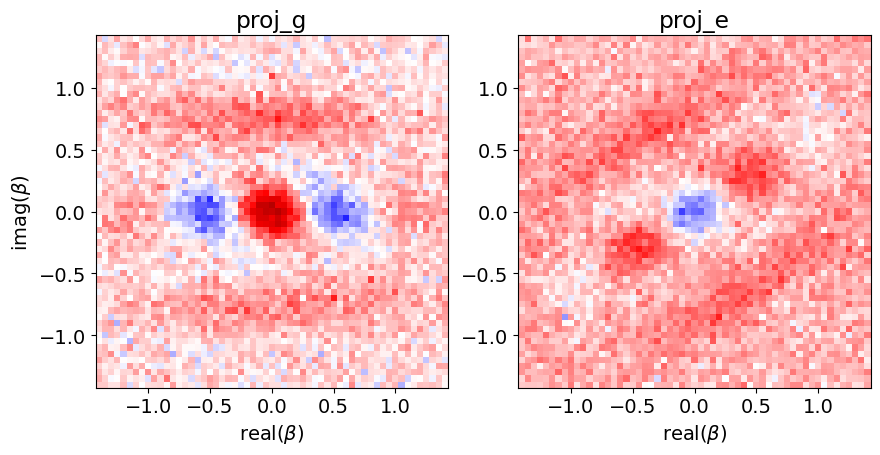

In [4]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma

import os
d = "C:/Users/jonat/Desktop/Coding/tcsim/Data Analysis/Data/"
files = [f for f in os.listdir(d) if f.endswith('091258_panther_cat_fringe_decay_real.h5')]
files[-2:-1]


dg = []
de = []

#files = files[-5:-1]

for kk in range(len(files)):
    fname = d + files[kk]
    df = h5py.File(fname, "r")
    data = df["data"]
    data_i = data["I"][:]
    x = data["x"][:, 0][:, 0]
    n_points = len(x)  # sweep points
    thresh = +0.00022 #-3.112326057411744e-05
    ss_data = np.where(data_i < thresh, 1, 0)
    m0 = ss_data[:, 0::3]
    m1 = ss_data[:, 1::3] 
    m2 = ss_data[:, 2::3]
    m1_g = ma.masked_array(m1, mask=m0)
    m2_g = ma.masked_array(m2, mask=m0)

    ## only care about last two measurements
    proj_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(n_points, n_points) * 2 - 1
    proj_e = ma.masked_array(m2, mask=np.logical_not(m1)).mean(axis=0).reshape(n_points, n_points) * 2 - 1

    ## condition on the first measurement as well
    double_ps_g = ma.masked_array(m2_g, mask=m1_g).mean(axis=0).reshape(n_points, n_points) * 2 - 1
    double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g)).mean(axis=0).reshape(n_points, n_points) * 2 - 1

    dg.append(double_ps_g)
    de.append(double_ps_e)

    
dg = np.array(dg)
de = np.array(de)


proj_g = dg.mean(axis=0)
proj_e = de.mean(axis=0)
proj_ge = [proj_g, proj_e]  # m2.mean(axis = 0).reshape(n_points, n_points)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
f1 = ax1.pcolormesh(x, x, proj_g, cmap="seismic", vmax=1, vmin=-1)
f2 = ax2.pcolormesh(x, x, proj_e, cmap="seismic", vmax=1, vmin=-1)
ax1.set_aspect("equal")
ax1.set_xlabel(r"real($\beta$)")
ax1.set_ylabel(r"imag($\beta$)")
ax1.set_title('proj_g')
ax2.set_aspect("equal")
ax2.set_xlabel(r"real($\beta$)")
ax2.set_title('proj_e')
# fig.colorbar(f2)


In [17]:
def reconstruct_char_from_data(data, x_data, y_data, dim, scale, plot=True):
  
    # turn x_data and y_data into an appropriate grid and flatten to hand it to reconstruct_char_complex as disps
    X, Y = np.meshgrid(x_data, y_data)
    
    disps = (1j*X + Y).flatten()
    
    #data = (data/np.min(data))
    
    # correct offset and scale data
    #data_scale_offset = (data - np.mean(data[0]))/np.max(data)
    rho = Qobj(reconstruct_char_complex(data.flatten(), disps*scale, dim))
    
    if plot:
        fig, ax = plt.subplots(1,3, figsize = (10,10) )
        ax[0].set_aspect('equal')
        ax[1].set_aspect('equal')
        ax[2].set_aspect('equal')
        ax[0].pcolormesh(x_data, y_data, data, cmap = 'bwr', vmin=-1, vmax = 1) 
        
        plot_char(qt.tensor(qt.fock(2,0).dag()*qt.fock(2,0),rho.unit()), ax=ax[1], max_alpha = scale, vmin = -1, vmax = 1)
        plot_char(qt.tensor(qt.fock(2,0).dag()*qt.fock(2,0),rho.unit()), ax=ax[2], real=False, max_alpha = scale,  vmin = -1, vmax = 1)
        ax[0].set_title("Experimental Data")
        ax[1].set_title("Recon char real")
        ax[2].set_title("Recon char im")
        
    return rho.unit()

def wigner_from_char(char,dx,scale):
    center=np.zeros(np.shape(char))
    center[char.shape[-1]//2,char.shape[-1]//2]=1
    f=np.fft.fftfreq(char.shape[-1],dx)*np.pi/scale
    f=np.fft.fftshift(f)
    wig=np.fft.fft2(char)/np.fft.fft2(center)
    wig=np.fft.fftshift(wig)*(dx**2/np.pi**2*scale**2)
    return wig, f

C:\Users\jonat\AppData\Local\Temp\ipykernel_20924\2350642312.py:62: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dm = np.zeros((n_disp, d*d), dtype=np.complex)
C:\Users\jonat\AppData\Local\Temp\ipykernel_20924\2350642312.py:46: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.diag(rvec[:d]).astype(np.complex) # 将r

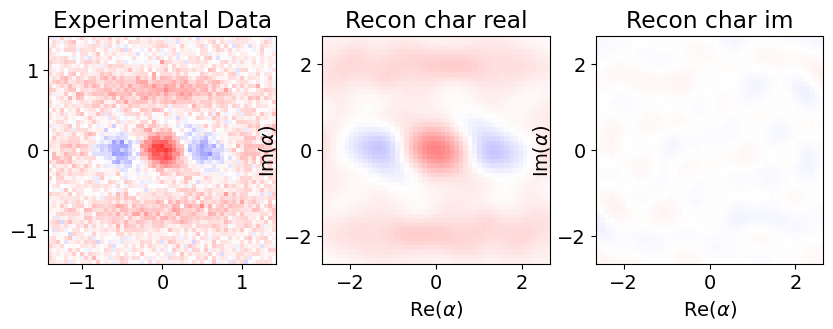

<Figure size 600x500 with 0 Axes>

<Figure size 600x500 with 0 Axes>

In [18]:
rho = reconstruct_char_from_data(proj_g, x, x, 20, scale=2.6)

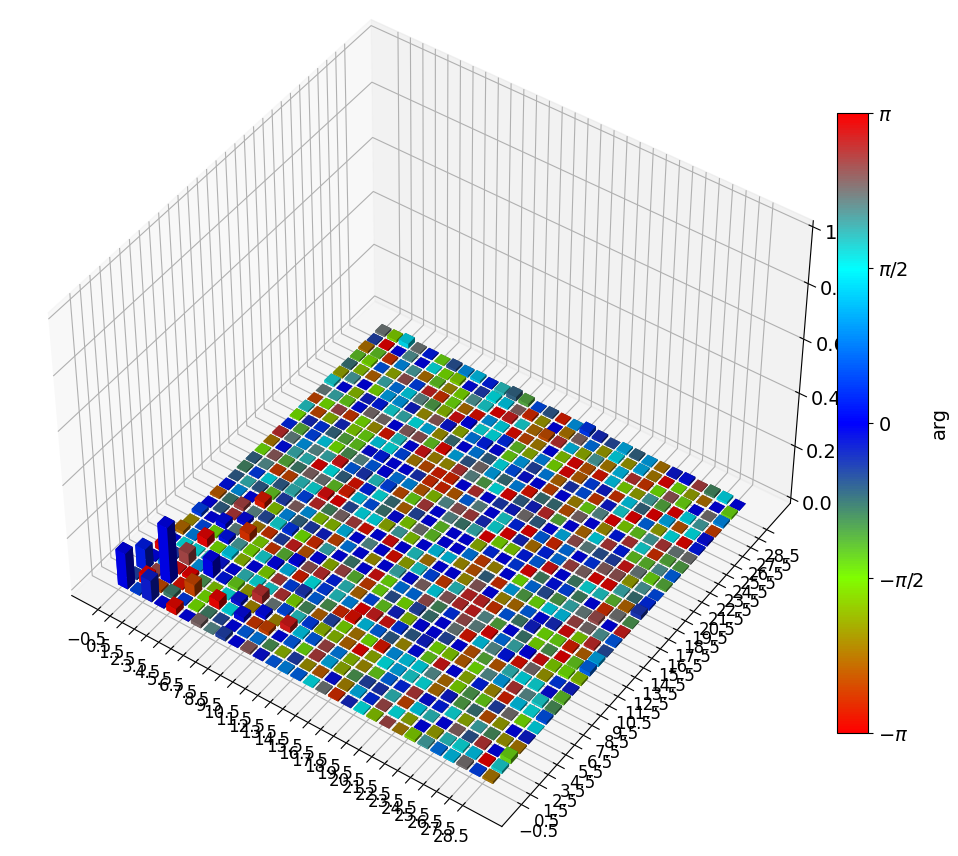

In [8]:
fig, ax = qt.matrix_histogram_complex(rho)
ax.view_init(azim=-55, elev=45)

plt.show()

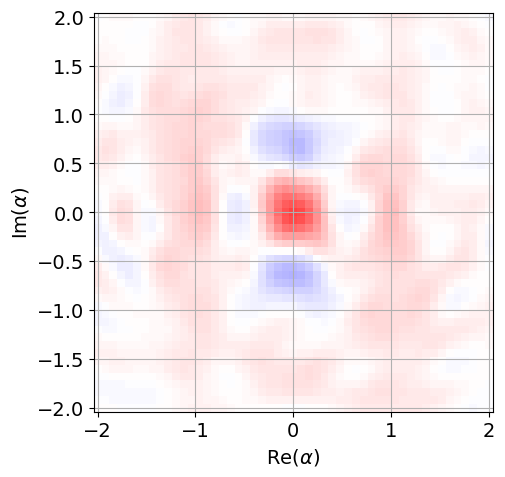

In [13]:
plot_wigner(tensor(fock(2,0)*fock(2,0).dag(),rho))

In [12]:
tensor(fock(2,0)*fock(2,0).dag(),rho)

Quantum object: dims = [[2, 20], [2, 20]], shape = (40, 40), type = oper, isherm = True
Qobj data =
[[ 0.16731564+0.j          0.00659565-0.00328807j  0.09890238+0.0180541j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.00659565+0.00328807j -0.04327277+0.j         -0.00970641+0.00546783j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.09890238-0.0180541j  -0.00970641-0.00546783j  0.26398851+0.j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 ...
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]]

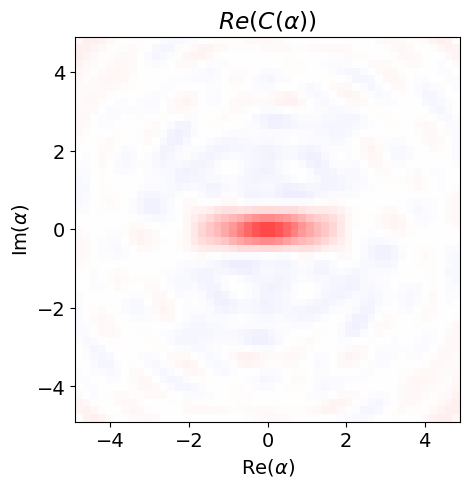

In [171]:
a = destroy(20)
def phase_operator(phase):
    return (1j*a.dag()*a*phase).expm()

angle = np.deg2rad(-13.4)
plot_char(qt.tensor(qt.fock(2,0).dag()*qt.fock(2,0),phase_operator(angle)*rho.unit()*phase_operator(angle).dag()), max_alpha = 1.2*4, vmin = -1, vmax = 1)

In [172]:
Q = (a + a.dag())/2
P = 1j*(a-a.dag())/2

rho_rotated = phase_operator(angle)*rho.unit()*phase_operator(angle).dag()

variance_P = expect(P**2,rho_rotated)
variance_Q = expect(Q**2,rho_rotated)

In [181]:
rho = reconstruct_char_from_data(proj_g, x, x, 20, scale=2, plot=False)
rho_rotated = phase_operator(angle)*rho.unit()*phase_operator(angle).dag()

variance_P = expect(P**2,rho_rotated)
variance_Q = expect(Q**2,rho_rotated)
print(variance_P)
print(variance_Q)

print( 10*np.log10(qt.expect(P**2,rho_rotated)*4))
print( 10*np.log10(qt.expect(Q**2,rho_rotated)*4))

C:\Users\jonat\AppData\Local\Temp\ipykernel_10972\2350642312.py:62: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dm = np.zeros((n_disp, d*d), dtype=np.complex)


2.1538782459448655
0.34037502295463806
9.352811412607792
1.3401767496448078


C:\Users\jonat\AppData\Local\Temp\ipykernel_10972\2350642312.py:46: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.diag(rvec[:d]).astype(np.complex) # 将rvec[:d]转化为一个对角矩阵，并且用a+jb的形式表示


In [187]:
rho = reconstruct_char_from_data(proj_g, x, x, 20, scale=3.5, plot=False)
rho_rotated = phase_operator(angle)*rho.unit()*phase_operator(angle).dag()

variance_P = expect(P**2,rho_rotated)
variance_Q = expect(Q**2,rho_rotated)
print(variance_P)
print(variance_Q)

print( 10*np.log10(qt.expect(P**2,rho_rotated)*4))
print( 10*np.log10(qt.expect(Q**2,rho_rotated)*4))

C:\Users\jonat\AppData\Local\Temp\ipykernel_10972\2350642312.py:62: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dm = np.zeros((n_disp, d*d), dtype=np.complex)


0.5256216123174963
0.11918191577649373
3.2273320540871984
-3.2172964650865383


C:\Users\jonat\AppData\Local\Temp\ipykernel_10972\2350642312.py:46: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ret = np.diag(rvec[:d]).astype(np.complex) # 将rvec[:d]转化为一个对角矩阵，并且用a+jb的形式表示


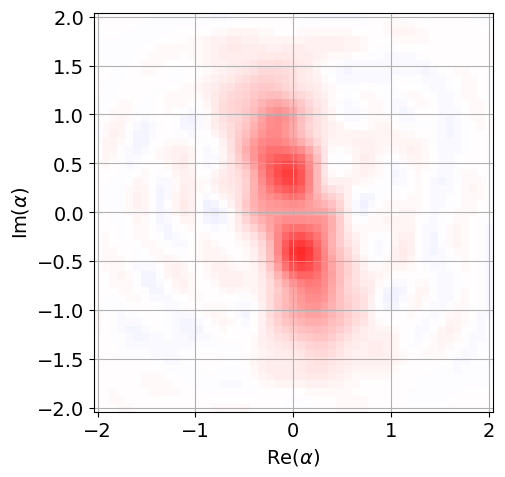

In [76]:
plot_wigner(tensor(fock(2,0)*fock(2,0).dag(),rho))

# Fit Gaussian

In [77]:
########################  2D plot ##################
import h5py
import matplotlib.pyplot as plt
import numpy as np
from qutip import*
import scipy.optimize as opt
# Everything in plae to be able to manipulate it quickly here if  needed.


N = 40
## cavity operators
a = tensor(destroy(N), qeye(2))
## qubit operator 
def char_func_grid(state, xvec):
    """Calculate the Characteristic function as a 2Dgrid (xvec, xvec) for a given state.

    Args:
        state (Qobject): State of which we want to calc the charfunc
        xvec (_type_): array of displacements. The char func will be calculated for the grid (xvec, xvec)

    Returns:
        tuple(ndarray, ndarray): Re(char func), Im(char func)
    """
    cfReal = np.empty((len(xvec),len(xvec)))
    cfImag = np.empty((len(xvec),len(xvec)))

    for i, alpha_x in enumerate(xvec):
        for j, alpha_p in enumerate(xvec):
            expect_value = expect(displace(N, alpha_x +1j*alpha_p),state)
            cfReal[i,j] =  np.real(expect_value)
            cfImag[i,j] =  np.imag(expect_value)

    return cfReal,cfImag  

def calc_squeez_parameter(dB):
    return np.log(10**(dB/10))/2

def twoD_Gaussian(xy_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x,y) = xy_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()


Text(0.5, 1.0, 'proj_g')

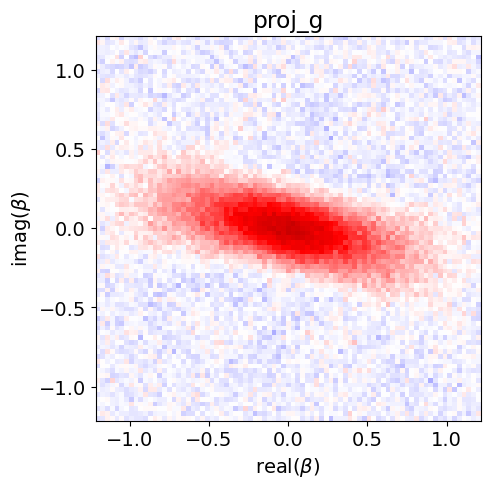

In [85]:
fig, ax1 = plt.subplots( figsize=(5, 5))
f1 = ax1.pcolormesh(x, x, proj_g, cmap="seismic", vmax=1, vmin=-1)
ax1.set_aspect("equal")
ax1.set_xlabel(r"real($\beta$)")
ax1.set_ylabel(r"imag($\beta$)")
ax1.set_title('proj_g')


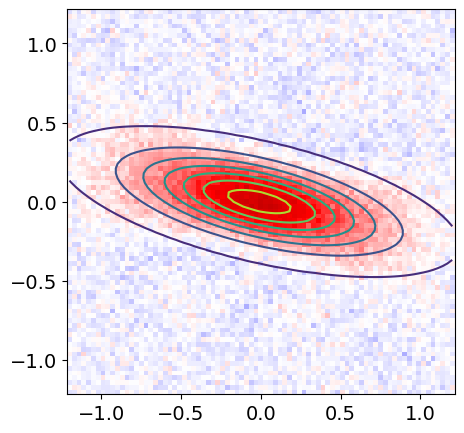

In [87]:
""" 
Use the above plot to make good intial guesses!

"""

# add some noise to the data and try to fit the data generated beforehand
initial_guess1 = (0.3, 0, 0, 0.6, 0.1, -np.pi/16, 0) # upper blob

x = x # i define it like this in case i want to slice x
y = x
X, Y = np.meshgrid(x, y)

data = proj_g

popt1, pcov1 = opt.curve_fit(twoD_Gaussian, (X, Y), data.flatten(), p0=initial_guess1)




data_fitted1 = twoD_Gaussian((X, Y), *popt1)


fig, ax = plt.subplots(1, 1, figsize = (5,5))

ax.pcolormesh(X,Y, data, cmap="seismic", vmin = -1, vmax = 1)
ax.contour(x,y, data_fitted1.reshape(len(y),len(x)))

plt.show()

In [83]:
print("First Blob")
print('xcenter:',popt1[1])
print('ycenter:',popt1[2])
print('|distance from origin| =',np.sqrt(popt1[1]**2+popt1[2]**2))
print("sigma ratio:",(popt1[3]/popt1[4]))
print('angle in degree:', np.rad2deg(popt1[5]))

First Blob
xcenter: -0.009697770427688995
ycenter: 0.0012537988213394225
|distance from origin| = 0.009778484685908717
sigma ratio: 3.3903610059013083
angle in degree: 13.421653261524948


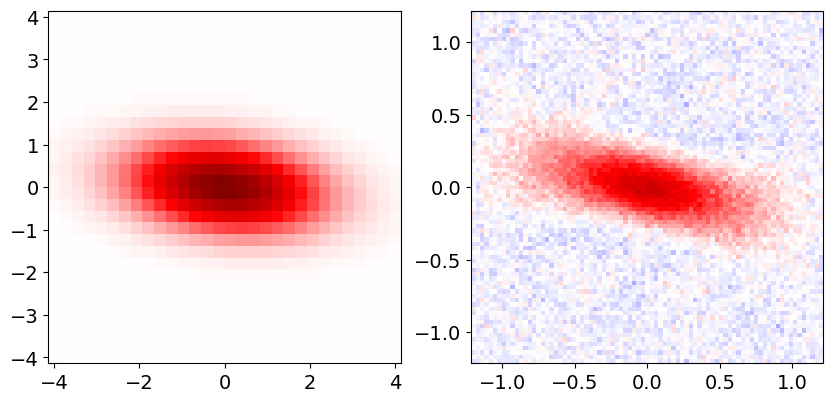

In [102]:
## tryout intelligent guesses to find a similair looking state to start out form
squeezing_db = 3.4
displacement = 0
angle = np.deg2rad(13.4)

xvec = np.linspace(-4,4,30)

state = (squeeze(N,calc_squeez_parameter(squeezing_db*np.exp(1j*angle)))*fock(N,0)).unit()
         
cf_real, cf_imag = char_func_grid(state,xvec)

fig, ax = plt.subplots(1,2, figsize=(10,10))
cs1= ax[0].pcolormesh(xvec, xvec, cf_real, cmap = 'seismic', vmin=-1, vmax=1, shading='auto')
ax[1].pcolormesh(X,Y, data, cmap = 'seismic', vmin=-1, vmax=1, shading='auto')
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')